In [2]:
import os
import random
import cv2
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [ ]:
# mndata = MNIST("rawdata")
# test_data = mndata.load_testing()
# for i,item in enumerate(zip(test_data[0],test_data[1])):

#     image,label = item
#     img = Image.fromarray(np.asarray(image).reshape((28,28))*255).resize((IMG_SIZE,IMG_SIZE))
#     img.save(f'data/test/img_{label}_{i}.png')

In [3]:
FOLDER = 'data'
BATCH_SIZE = 16
EPOCHS = 25
LR = 0.001
IMG_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

img_transform = transforms.Compose([
#     transforms.RandomCrop(int(0.8*IMG_SIZE)),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
#     transforms.RandomAffine(degrees=30,translate=(0.1,0.1),scale=(0.8,1.2)),
    transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5)),
])

In [4]:
class ImageDataset(Dataset):

    def __init__(self,folder,transform=None,test=False,display=None):
        
        self.folder = folder
        self.traintest = "test" if test else "train"
        self.data = os.listdir(f'data/{self.traintest}')
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])
        
        self.display = display
        
        if self.display != None:
            print(f'We will only be displaying the {self.display}th element.')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        
        if self.display != None:
            index = self.display
            
        item = self.data[index]
        label = int(item.split("_")[1])
        
        img = Image.open(f'data/{self.traintest}/{item}')
        
        
        if self.transform:
            image = self.transform(img)
        
        image = (image-image.min())/(image.max()-image.min())
        image = torch.where(image>0.5,1,0).float()
        
        return image, label

In [5]:
dataset = ImageDataset(FOLDER,transform=img_transform,display=0)

We will only be displaying the 0th element.


In [6]:
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
    )

P:\ProgramData\Anaconda\lib\site-packages\torchvision\transforms\functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


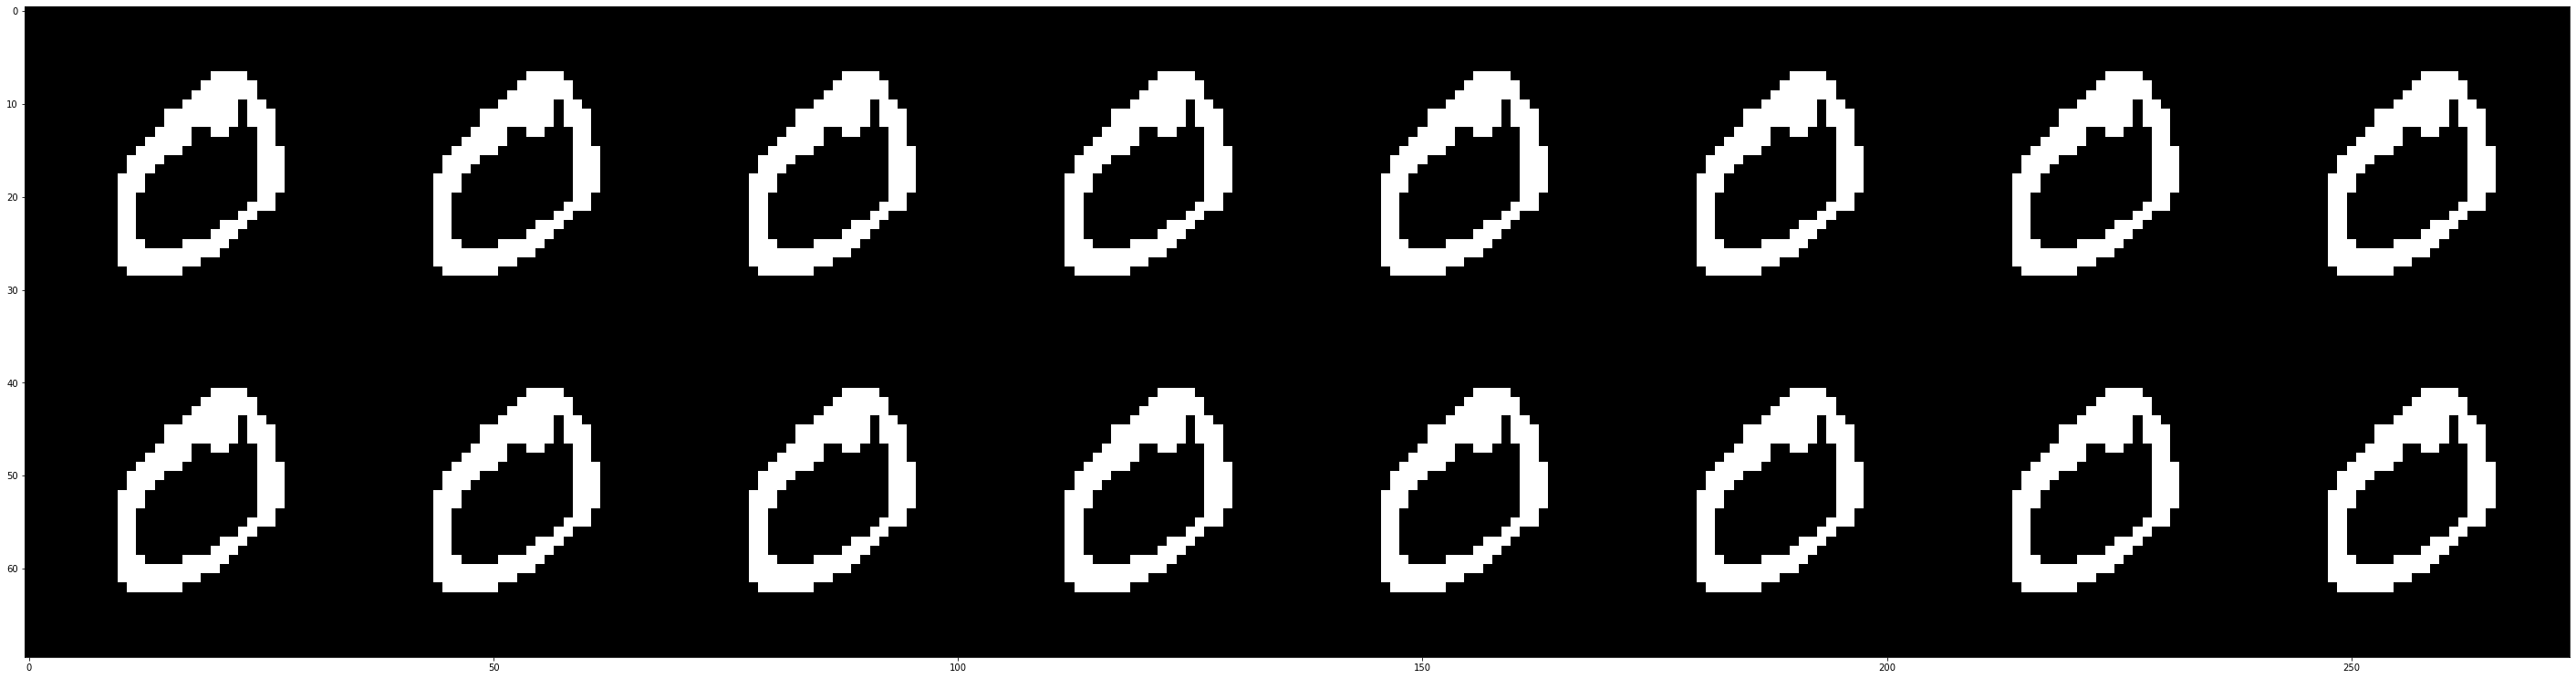

In [7]:
images,labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

In [8]:
class Encoder(nn.Module):
    def __init__(self,channels):
        super().__init__()     
        
        
        self.conv1 = nn.Conv2d(channels,64,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(64,128,4,stride=2,padding=1)
        
        self.mp = nn.MaxPool2d(2,2)
         

    def forward(self, x):
        
        out = self.conv1(x)
        out = self.mp(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.mp(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.mp(out)
        out = F.relu(out)
        out= self.conv4(out)
        out = self.mp(out)
        out = F.relu(out)
        
        
        return out.view(out.shape[0],-1)


In [9]:
class Decoder(nn.Module):
    def __init__(self,channels):
        super().__init__()     
        
        self.transconv1 = nn.ConvTranspose2d(64+32,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,channels,3,1,1)
        
        self.digitEmbedding = nn.Embedding(10,32)

        
    def forward(self,x,labels):
        
        digit = self.digitEmbedding(labels)
        z = torch.cat([x,digit],dim=1)

        out = self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out = self.transconv2(out)
        out = F.relu(out)
        out = self.transconv3(out)
        out = F.relu(out)
        out = self.transconv4(out)
        out = torch.sigmoid(out)

        return out


In [10]:
class cVAE(nn.Module):
    def __init__(self,channels):
        super().__init__()
        
        self.encoder = Encoder(channels)
        self.decoder = Decoder(channels)
        
    def forward(self,x,labels):
        
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        s = torch.exp(logvar/2)
        eps = torch.randn_like(s)
        z = s*eps + mu 

        out = self.decoder(h[:,:64],labels)
    
        return out,mu,logvar

In [11]:
dataset = ImageDataset(FOLDER)
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [14]:
def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)  - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    RL = F.mse_loss(recon_x,x)
    return RL + KLD

In [13]:
cvae = cVAE(1)
cvae.to(device)
optimizer = torch.optim.Adam(cvae.parameters(),lr=LR,weight_decay=1e-5)

In [15]:
losses = []

for e in range(EPOCHS):
    total_loss = 0
    for images,labels in tqdm(dataloader):

        labels = labels.to(device)
        images = images.to(device)

        output,mu,logvar = cvae(images,labels)
        loss = loss_function(output,images,mu,logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        total_loss += loss.detach().cpu()
        
    print(f'Epoch {e}: {total_loss}')        
    losses.append(total_loss/len(dataloader))
 

  4%|███▏                                                                            | 1/25 [11:49<4:43:36, 709.01s/it]

Epoch 0: 120.24736785888672


  8%|██████▍                                                                         | 2/25 [14:48<3:30:51, 550.07s/it]

Epoch 1: 77.93173217773438


 12%|█████████▌                                                                      | 3/25 [17:49<2:41:04, 439.31s/it]

Epoch 2: 71.51751708984375


 16%|████████████▊                                                                   | 4/25 [20:32<2:04:48, 356.59s/it]

Epoch 3: 68.59517669677734


 20%|████████████████                                                                | 5/25 [21:29<1:28:53, 266.65s/it]

Epoch 4: 66.89915466308594


 24%|███████████████████▏                                                            | 6/25 [22:26<1:04:33, 203.88s/it]

Epoch 5: 65.67218017578125


 28%|██████████████████████▉                                                           | 7/25 [23:22<47:48, 159.34s/it]

Epoch 6: 64.87889099121094


 32%|██████████████████████████▏                                                       | 8/25 [24:21<36:37, 129.27s/it]

Epoch 7: 64.19371032714844


 36%|█████████████████████████████▌                                                    | 9/25 [25:16<28:32, 107.03s/it]

Epoch 8: 63.742576599121094


 40%|████████████████████████████████▊                                                 | 10/25 [26:14<23:06, 92.46s/it]

Epoch 9: 63.18490219116211


 44%|████████████████████████████████████                                              | 11/25 [27:13<19:10, 82.18s/it]

Epoch 10: 62.88534927368164


 48%|███████████████████████████████████████▎                                          | 12/25 [28:12<16:19, 75.33s/it]

Epoch 11: 62.553977966308594


 52%|██████████████████████████████████████████▋                                       | 13/25 [29:10<14:01, 70.15s/it]

Epoch 12: 62.23857498168945


 56%|█████████████████████████████████████████████▉                                    | 14/25 [30:08<12:10, 66.37s/it]

Epoch 13: 61.946739196777344


 60%|█████████████████████████████████████████████████▏                                | 15/25 [31:03<10:31, 63.14s/it]

Epoch 14: 61.81741714477539


 64%|████████████████████████████████████████████████████▍                             | 16/25 [32:01<09:13, 61.51s/it]

Epoch 15: 61.68757629394531


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [32:57<07:59, 59.99s/it]

Epoch 16: 61.43362045288086


 72%|███████████████████████████████████████████████████████████                       | 18/25 [33:55<06:53, 59.14s/it]

Epoch 17: 61.236915588378906


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [34:50<05:48, 58.16s/it]

Epoch 18: 61.09946060180664


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [35:49<04:51, 58.30s/it]

Epoch 19: 60.98861312866211


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [36:48<03:53, 58.45s/it]

Epoch 20: 60.910240173339844


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [37:46<02:55, 58.39s/it]

Epoch 21: 60.7481689453125


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [38:45<01:56, 58.47s/it]

Epoch 22: 60.72150421142578


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [39:42<00:58, 58.05s/it]

Epoch 23: 60.54297637939453


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [40:38<00:00, 97.53s/it]

Epoch 24: 60.488525390625


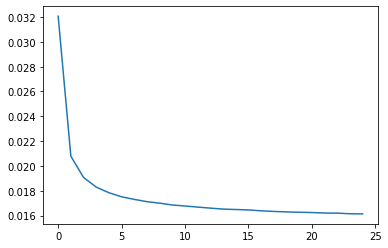

In [16]:
plt.plot(losses);

In [17]:
cvae = cvae.cpu()

In [68]:
images,labels = next(iter(dataloader))
list(enumerate(labels))

[(0, tensor(6)),
 (1, tensor(7)),
 (2, tensor(0)),
 (3, tensor(8)),
 (4, tensor(2)),
 (5, tensor(4)),
 (6, tensor(4)),
 (7, tensor(0)),
 (8, tensor(1)),
 (9, tensor(7)),
 (10, tensor(0)),
 (11, tensor(7)),
 (12, tensor(3)),
 (13, tensor(0)),
 (14, tensor(3)),
 (15, tensor(3))]

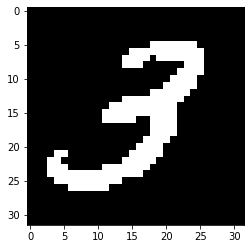

In [80]:
choice = 15
plt.imshow(images[choice].squeeze(),cmap="gray")

In [81]:
with torch.no_grad():
    output,_,_ = cvae(images,labels)

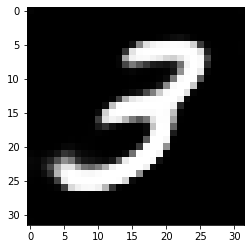

In [82]:
plt.imshow(output[choice].squeeze().cpu(),cmap="gray")

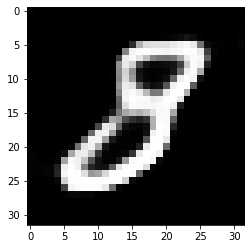

In [88]:
with torch.no_grad():
    new_output,_,_ = cvae(images[choice].unsqueeze(0),torch.LongTensor([8]))
plt.imshow(new_output.squeeze(),cmap="gray")

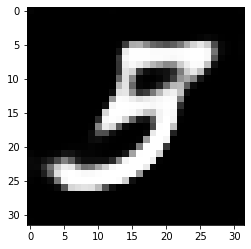

In [91]:
with torch.no_grad():
    new_output,_,_ = cvae(images[choice].unsqueeze(0),torch.LongTensor([5]))
plt.imshow(new_output.squeeze(),cmap="gray")

In [ ]:
# torch.save(model.state_dict(),"models/auto1.pkl")

In [ ]:
# model = CNN(1,10).to("cuda")
# model.load_state_dict(torch.load("models/auto1.pkl"))

In [ ]:
testset = ImageDataset(FOLDER,test=True)
testloader = DataLoader(
    testset, 
    batch_size=200,
    shuffle=True
    )

In [ ]:
images,labels = next(iter(testloader))
output_images,output_labels = model(images.float().to("cuda"))
output_images = output_images.cpu()
output_labels = output_labels.cpu()
sample = torch.cat((images[:16],output_images[:16]),dim=0)
grid = torchvision.utils.make_grid(sample,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

In [ ]:
model.encode(values[0][0].unsqueeze(0).float().to("cuda")).shape

In [ ]:
values = []
gt = []
for i in range(10):
    samples = images[labels==i].clone()
    values.append(samples)
    gt += [i for _ in range(len(samples))]

In [ ]:
outputs = []
with torch.no_grad():
    for i in range(10):
        outputs.append(model.encode(values[i].float().to("cuda")).reshape(-1,3).cpu())

In [ ]:
ls = outputs[0]
for i in range(9):
    ls = torch.cat((ls,outputs[i+1]))

In [ ]:
ls

In [ ]:
# from sklearn.manifold import TSNE

In [ ]:
# tsne = TSNE(n_components=3)
# ls2 = tsne.fit_transform(ls)

In [ ]:
df = pd.DataFrame(ls.numpy(),columns=["Component 0","Component 1","Component 2"])

In [ ]:
df.loc[:,"Label"] = gt

In [ ]:
df[["Component 0","Component 1","Component 2"]] -= df[["Component 0","Component 1","Component 2"]].mean()
df[["Component 0","Component 1","Component 2"]] /= df[["Component 0","Component 1","Component 2"]].std()

df.head()

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 10))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(10):
    ax.scatter3D(df[df.Label==i].iloc[:,0],df[df.Label==i].iloc[:,1],df[df.Label==i].iloc[:,2],color=colors[i],label=f'{i}')
plt.legend();

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(df[df.Label==0].iloc[:,0],df[df.Label==0].iloc[:,1],df[df.Label==0].iloc[:,2],color="r",label="0")
ax.scatter3D(df[df.Label==1].iloc[:,0],df[df.Label==1].iloc[:,1],df[df.Label==1].iloc[:,2],color="b",label="1")
ax.scatter3D(df[df.Label==7].iloc[:,0],df[df.Label==7].iloc[:,1],df[df.Label==7].iloc[:,2],color="g",label="7")
# ax.scatter3D(df[df.Label==9].iloc[:,0],df[df.Label==9].iloc[:,1],df[df.Label==9].iloc[:,2],color="orange",label="9")
plt.legend();

In [ ]:
np.where(labels==output_labels.argmax(axis=1),1,0).sum()/200

In [ ]:
output_labels.argmax(axis=1)

In [ ]:
def GradCAM(X):

    X = X.unsqueeze(0).float()
    # plt.imshow(X.squeeze(),cmap="gray")

    model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    '''
    forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
    and we also don't need softmax, we need scores, so that's perfect for us.
    '''

    scores = model(X.to("cuda")).cpu()



    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()

    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    # code to plot the saliency map as a heatmap
    f,axi = plt.subplots(1,2)
    axi[0].imshow(X.detach().squeeze(),cmap="gray")
    axi[1].imshow(saliency.squeeze(), cmap=plt.cm.hot)
    axi[0].set_title(f'{score_max_index}')
    plt.axis('off')
    plt.show()
    

In [ ]:
GradCAM(images[0])

In [ ]:
GradCAM(images[3])

In [ ]:
GradCAM(images[50])

In [ ]:
with torch.no_grad():
    top_losses = torch.topk(nn.CrossEntropyLoss(reduce=False,size_average=False)(predictions.to("cuda"),labels.to("cuda")).cpu(),8)
top_losses[1]

In [ ]:
GradCAM(images[26])